In [1]:
import rasterio
import pandas as pd
import geopandas as gpd
import csv
import numpy as np
import os
from rasterio.merge import merge
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Polygon, MultiPolygon, Point, mapping
import ast
from rasterio.mask import mask, raster_geometry_mask
import requests
from time import sleep

def align_extent_raster(reference_path, tiff_to_be_aligned):
    """
    Aligns the extent of a raster to match that of a reference raster.

    Parameters:
    ----------
    raster_reference : rasterio.io.DatasetReader
        The reference raster whose extent and profile are used.
    tiff_to_be_aligned : rasterio.io.DatasetReader
        The raster that needs to be aligned to the reference raster.

    Returns:
    -------
    np.array
        The aligned raster is returned as an array.
    """
    with rasterio.open(reference_path, "r") as raster_reference:

        bounds1 = raster_reference.bounds
        
    transform_2 = tiff_to_be_aligned.transform

    window = rasterio.windows.from_bounds(*bounds1, transform=transform_2)

    smaller_array = tiff_to_be_aligned.read(window=window, boundless=True) 
    return smaller_array



#{6: 'Sudan', 8: 'Angola', 29: 'Benin', 35: 'Botswana', 42: 'Burkina Faso', 45: 'Cameroon', 47: 'Cape Verde', 49: 'Central African Republic',
#50: 'Chad', 58: 'Comoros', 59: 'Congo', 66: "Côte d'Ivoire", 68: 'Democratic Republic of the Congo', 70: 'Djibouti', 74: 'South Sudan',
#76: 'Equatorial Guinea', 77: 'Eritrea', 79: 'Ethiopia', 89: 'Gabon', 90: 'Gambia', 94: 'Ghana', 105: 'Guinea-Bissau', 106: 'Guinea', 133: 'Kenya',
#142: 'Lesotho', 144: 'Liberia', 150: 'Madagascar', 152: 'Malawi', 155: 'Mali', 159: 'Mauritania', 160: 'Mauritius', 170: 'Mozambique', 172: 'Namibia',
#181: 'Niger', 182: 'Nigeria', 217: 'Senegal', 220: 'Seychelles', 221: 'Sierra Leone', 226: 'Somalia', 227: 'South Africa', 235: 'Swaziland', 243: 'Togo',
#253: 'Uganda', 257: 'United Republic of Tanzania', 270: 'Zambia', 271: 'Zimbabwe', 4: 'Algeria', 43: 'Burundi', 102: 'Abyei', 145: 'Libya', 169: 'Morocco',
#205: 'Rwanda', 214: 'Sao Tome and Principe', 248: 'Tunisia', 268: 'Western Sahara', 40760: "Hala'ib triangle", 40762: "Ma'tan al-Sarra", 40765: 'Egypt',
#61013: 'Ilemi triangle'}

def get_geodata(adm0, admin2: bool=False):
    """
    creates a dataframe with the wfp geometries
    :param adm0: gets the country code as set from wfp, e.g., 79 for Ethiopia, and 182 for Nigeria
    :param admin2: gets both admin2 and admin1 data; default is False
    :return: a dataframe with the wfp geometries
    """

    # for admin1
    req = requests.get(f"https://api.vam.wfp.org/geodata/GetGeoAdmins?adm0={adm0}&admcode={adm0}", headers = {'User-agent': f'your bot {adm0}'})
    req.raise_for_status()  # raises exception when not a 2xx response
    # if req.status_code != 204:
    #     return req.json()
    sleep(10)

    geo_df = gpd.GeoDataFrame.from_features(req.json()['features'])

    # for admin2
    if admin2==True:
        # rename columns
        geo_df = geo_df.rename(columns={'geometry': 'geometry_adm1', "Code": "Code_adm1", "Name": "Name_adm1"})
        #create an empty df to use
        all_adm2 = pd.DataFrame(columns=['geometry', 'Code', 'Name', 'Code_adm1'])
        for code in geo_df.Code_adm1:
            # print(code)
            req_adm2 = gpd.GeoDataFrame.from_features(requests.get(f"https://api.vam.wfp.org/geodata/GetGeoAdmins?adm0={adm0}&admcode={code}").json()["features"])
            req_adm2['Code_adm1'] = code
            all_adm2 = pd.concat([req_adm2, all_adm2])
            sleep(0.5)
        #merge
        geo_df = pd.merge(geo_df, all_adm2, on='Code_adm1')
    
    geo_df.set_crs('EPSG:4326', inplace = True)
    return geo_df


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/7z/xy3tglwx2_dgnz41stkj54pc0000gn/T/ipykernel_51929/3172414730.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.rea

## Aggregating data at Admin 2

In [14]:
# get the country iso3 list from the computed accessibility directory
# List of countries

country_ls = os.listdir('./computed_acc')
global_gdf = gpd.GeoDataFrame()

If computing at Admin 2, run the following cell a couple of times because sometimes the request fails in the first pass.

In [16]:

request_fails = []

# This geodataframe comes from the Open Africa data portal and contains the country borders along with iso3 
# names and numerical codes. The numerical codes coincide with the WFP codes used in the API except for 3 countries.
# The countries are: South Sudan (74), Egypt (40765), and Libya (145). 'wrong_numbers' corrects the 
# wrong codes to the WFP ones.

africa_gdf = gpd.read_file('../shared_data/africa_borders/afr_g2014_2013_0.shp')
wrong_numbers = {74:70001, 6: 40764, 217:278}

for country_iso3 in country_ls:
    # print(country_iso3)
    # since we list the files in a directory, we only use the ones that actually are an iso3 code (in Africa).
    try:
        country_num = int(africa_gdf.loc[africa_gdf['ISO3'] == country_iso3.upper()]['ADM0_CODE'].values[0])
        print('country num: ', country_num)
    except:
        # usually woth files such as .DS_store
        continue   

    # Load WorldPop raster of the country to get extent and transform
    for path in os.listdir(f"../shared_data/worldpop_rasters/{country_iso3}"):
        if path.endswith('UNadj.tif'):
            chosen_path = path
    wpp_path = f"../shared_data/worldpop_rasters/{country_iso3}/{chosen_path}"
    with rasterio.open(wpp_path, "r") as src:
        transform = src.transform
        worldpop_arr = src.read()[0]
        worldpop_arr = np.where(worldpop_arr<0, 0, worldpop_arr)
        
    # print('loaded population')
    en_path = f'./computed_acc/{country_iso3}/entropy_mod_4h_moto.tif'
    shortest_tt_path = f'./computed_acc/{country_iso3}/shortest_moto_tt.tif'
    shortest_walinkg_tt_path = f'./computed_acc/{country_iso3}/shortest_walk_tt.tif'
    acc_path_pure_cumul = f'./computed_acc/{country_iso3}/acc_pure_cumul_moto.tif'
    
    with rasterio.open(en_path, 'r') as f:
        entropy = align_extent_raster(wpp_path, f)[0]

    # print('loaded entropy')

    with rasterio.open(shortest_tt_path, 'r') as f:
        shortest_tt = align_extent_raster(wpp_path, f)[0]


    with rasterio.open(shortest_walinkg_tt_path, 'r') as f:
        shortest_walking_tt = align_extent_raster(wpp_path, f)[0]

    # print('loaded shortest tt.')

    with rasterio.open(acc_path_pure_cumul, 'r') as f:
        acc_pure_cumul = align_extent_raster(wpp_path, f)[0]

    # Load country boundaries
    try:
        if country_num in wrong_numbers.keys():
            correct_num = wrong_numbers[country_num]
        else:
            correct_num = country_num
        country_adm_gdf = get_geodata(correct_num, True)
        country_adm_gdf['country_num'] = np.ones(len(country_adm_gdf))*country_num
        
    except Exception as e:
        print('Exception: ', e)
        request_fails.append(country_iso3)
        continue

    short_tt_admin = []
    entropy_adm = []
    pure_cumul_adm = []
    walk_tt_adm = []
    populations = []
    
    for i, poly in enumerate(country_adm_gdf['geometry']):
        wpp_rast = rasterio.open(wpp_path, "r")
        
        clipped_wpp, _, _ =  raster_geometry_mask(wpp_rast, [mapping(poly)], 
                                                crop=False, invert = True, all_touched = True)
        
        true_points = ~(np.ones_like(clipped_wpp)&clipped_wpp)

        pure_cumul_masked = np.copy(acc_pure_cumul)
        pure_cumul_masked[true_points] = 0
    
        shortest_tt_rast_masked = np.copy(shortest_tt)
        shortest_tt_rast_masked[true_points] = 0
        
        shortest_tt_walking_masked = np.copy(shortest_walking_tt)
        shortest_tt_walking_masked[true_points] = 0
            
        entropy_masked = np.copy(entropy)
        entropy_masked[true_points] = 0
    
        pop_masked_arr = np.copy(worldpop_arr)
        pop_masked_arr[true_points] = 0
    
        pop_masked_arr[pop_masked_arr < 0] = 0
        tot_pop = np.sum(pop_masked_arr)
    
        pop_masked_arr_tt = np.copy(pop_masked_arr)
        pop_masked_arr_tt[np.isinf(shortest_tt_rast_masked)] = np.nan
        pop_masked_arr_tt[np.isnan(shortest_tt_rast_masked)] = np.nan
    
        shortest_tt_rast_masked[np.isinf(shortest_tt_rast_masked)] = np.nan
        shortest_tt_rast_masked[np.isnan(shortest_tt_rast_masked)] = np.nan

        shortest_tt_walking_masked[np.isinf(shortest_tt_walking_masked)] = np.nan
        shortest_tt_walking_masked[np.isnan(shortest_tt_walking_masked)] = np.nan
        
        pop_masked_arr_entropy = np.copy(pop_masked_arr)
        pop_masked_arr_entropy[np.isinf(entropy_masked)] = np.nan
        pop_masked_arr_entropy[np.isnan(entropy_masked)] = np.nan
    
        entropy_masked[np.isinf(entropy_masked)] = 0
        entropy_masked[np.isnan(entropy_masked)] = 0
        
    
        if tot_pop > 0:
            
            weighted_mean_pure_cumul = np.nansum(pop_masked_arr[np.isfinite(pop_masked_arr) & np.isfinite(pure_cumul_masked)] *\
                                             pure_cumul_masked[np.isfinite(pop_masked_arr) & np.isfinite(pure_cumul_masked)]/np.nansum(pop_masked_arr[np.isfinite(pure_cumul_masked)]))
            
            weighted_mean_tt = np.nansum(pop_masked_arr[np.isfinite(shortest_tt_rast_masked)] * shortest_tt_rast_masked[np.isfinite(shortest_tt_rast_masked)]\
                                      /np.nansum(pop_masked_arr[np.isfinite(shortest_tt_rast_masked) & np.isfinite(pop_masked_arr)]))

            weighted_mean_walking_tt = np.nansum(pop_masked_arr[np.isfinite(shortest_tt_walking_masked)] * shortest_tt_walking_masked[np.isfinite(shortest_tt_walking_masked)]\
                                      /np.nansum(pop_masked_arr[np.isfinite(shortest_tt_walking_masked) & np.isfinite(pop_masked_arr)]))
            
            weighted_mean_entr = np.nansum(pop_masked_arr[np.isfinite(entropy_masked)] * entropy_masked[np.isfinite(entropy_masked)]\
                                        /np.nansum(pop_masked_arr[np.isfinite(entropy_masked)]))
            
    
        else:
            # Handle cases where population is zero to avoid division by zero
            weighted_mean_tt = 0
            weighted_mean_entr = 0 
            weighted_mean_pure_cumul = 0
            weighted_mean_walking_tt = 0
            
        populations.append(tot_pop)
        short_tt_admin.append(weighted_mean_tt)
        entropy_adm.append(weighted_mean_entr)
        pure_cumul_adm.append(weighted_mean_pure_cumul)
        walk_tt_adm.append(weighted_mean_walking_tt)
        
    country_adm_gdf = country_adm_gdf[[c for c in country_adm_gdf.columns if 
                                           not c.endswith('_right') and not 
                                           c.endswith('_left') and not 
                                           c.endswith('_y')]]
    
    country_adm_gdf['tot_pop'] = populations
    country_adm_gdf['travelt_moto'] = short_tt_admin
    country_adm_gdf['entropy'] = entropy_adm
    country_adm_gdf['cumulative'] = pure_cumul_adm
    country_adm_gdf['travelt_walk'] = walk_tt_adm
    country_adm_gdf['country_name'] = [country_iso3 for g in range(len(country_adm_gdf))]
    
    if len(global_gdf) == 0:
        global_gdf = country_adm_gdf
    else:
        global_gdf = gpd.GeoDataFrame(pd.concat([global_gdf, country_adm_gdf], ignore_index=True), crs = country_adm_gdf.crs)
    
    # sleep(5)
country_ls = request_fails
print(country_ls)
    

country num:  66
Exception:  Expecting value: line 1 column 1 (char 0)
country num:  253
Exception:  429 Client Error: Too Many Requests for url: https://api.vam.wfp.org/geodata/GetGeoAdmins?adm0=253&admcode=253
country num:  182
country num:  106
Exception:  string indices must be integers
['civ', 'uga', 'gin']


In [29]:
global_gdf.drop(columns = ['geometry_adm1']).to_file('../../access_adm_2.geojson')

<Axes: >

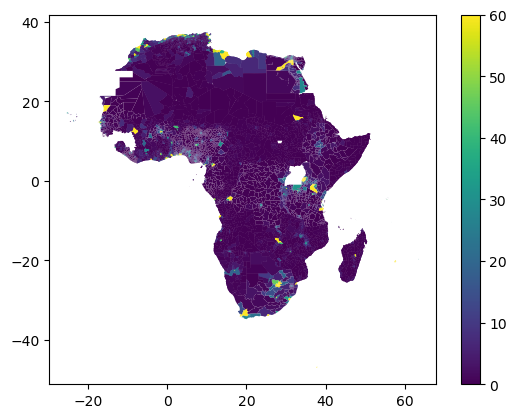

In [36]:
global_gdf.plot(column = 'cumulative', legend = True, vmin = 0, vmax = 60)